In [8]:
import networkx as nx
import matplotlib.pyplot as plt

from collections import deque

from path_search_visualization import animate_search

%matplotlib widget

In [9]:
DEFAULT_COLOR = "#0064e1"

def graph_factory():

    node_positions = {
        "S": (0, 0),
        "A": (0, 2),
        "B": (1, 1),
        "C": (2, 3),
        "D": (3, 1),
        "E": (3, 2),
        "G": (4, 3),
    }

    node_colors = {node: DEFAULT_COLOR for node in node_positions.keys()}

    node_attrs = {"positions": node_positions, "colors": node_colors}

    G = nx.Graph()

    G.add_weighted_edges_from(
        [
            ("S", "A", 2),
            ("S", "B", 4),
            ("A", "C", 2),
            ("B", "C", 1),
            ("C", "E", 4),
            ("B", "D", 1),
            ("D", "E", 2),
            ("E", "G", 5)
        ]
        )

    return G, node_attrs

## Animate the graph

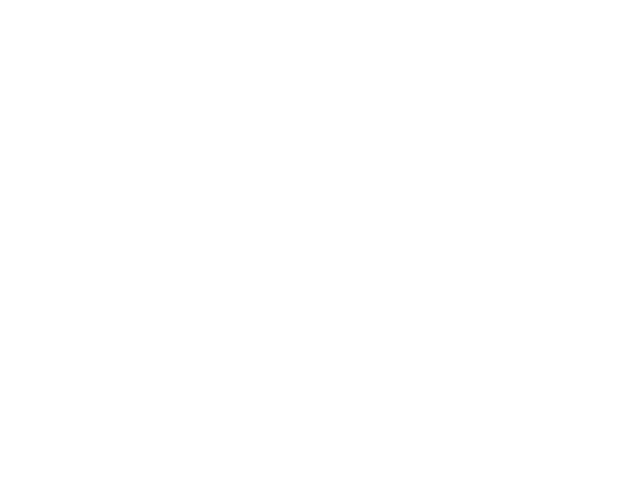

In [50]:
def dfs(G, start, end):
    assert start in G, f"{start} node not in Graph"
    assert end in G, f"{end} node not in Graph"
    
    q = deque([[start]])
    visited = set()
    explored_paths = []

    while q:
        
        path = q.popleft()
        last_node = path[-1]
        explored_paths.append(path)
        
        if last_node == end:
            return explored_paths

        if last_node in visited:
            continue

        visited.add(last_node)

        for neighbor in sorted(list(G.adj[last_node])):
            if neighbor not in visited:
                q.appendleft(path + [neighbor])

    return []


G, node_attrs = graph_factory()

fig, ax = plt.subplots()
ax.axis("off")
explored_paths = dfs(G, "S", "G")
    
ani = animate_search(fig, ax, G, node_attrs["positions"], explored_paths)
plt.show()

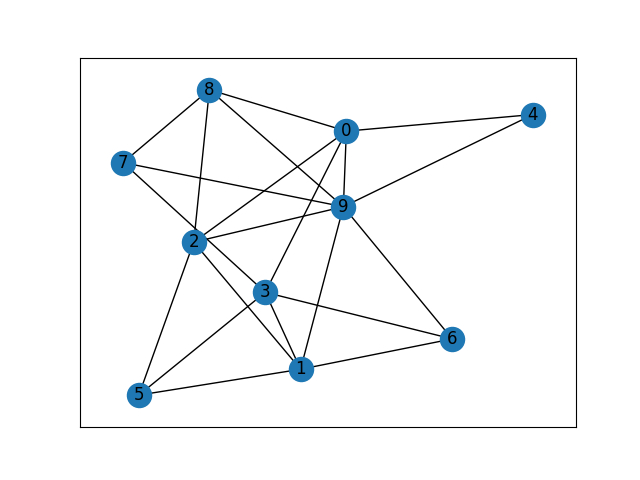

In [63]:
G = nx.erdos_renyi_graph(10, 0.5, seed=42)
positions = nx.spring_layout(G)

fig, ax = plt.subplots()
nx.draw_networkx(G, pos=positions, ax=ax)
plt.show()

In [60]:
explored_paths = dfs(G, 0, 5)

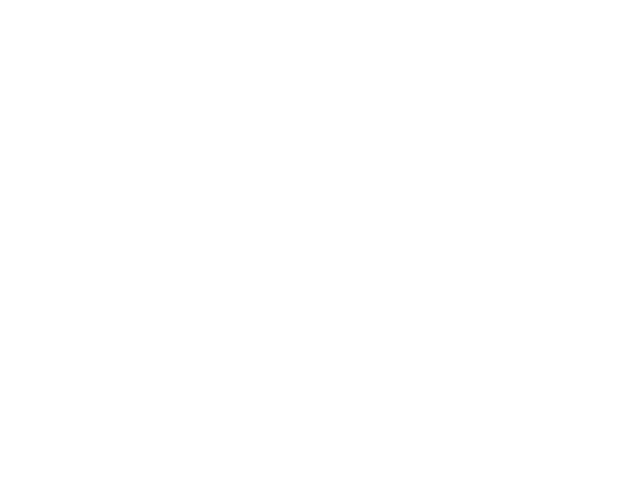

In [61]:
fig, ax = plt.subplots()
ax.axis("off")   
ani = animate_search(fig, ax, G, positions, explored_paths)
plt.show()